In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import mglearn
#import t_Mod
from t_Mod import *
#from t_Mod.plots_t import *

In [3]:
df = pd.read_csv(
    os.path.join(mglearn.datasets.DATA_PATH, "constant(del).csv") )
#df2 = pd.read_csv(
#    os.path.join(mglearn.datasets.DATA_PATH, "constant(val).csv") )
# 예제를 위해 몇개의 열만 선택합니다
#df = df[['IR', 'FlowHt', 'Const', 'Var', 'Base', 'MixS75','MixS50','MixS25']]
#df = df[['IR', 'FlowHt', 'Sand','Ash','delIR','delFlow']]
df = df[['IR', 'FlowHt', 'Sand','Ash','delIR','delFlow']]
#df2 = df2[['IR', 'FlowHt', 'Sand','Ash']]
df['delIF'] = df['delFlow']/df['delIR']*-1

df['delIF']=df['delIF'].replace(np.nan, 0)
df = df[['IR', 'FlowHt', 'Sand','Ash','delIR' ]]

display(df.head())
#display(df2.head())

,IR,FlowHt,Sand,Ash,delIR
0,1.0000,0.0000,1.0,0.0,0.0000
1,0.9995,0.1798,1.0,0.0,-0.0005
2,0.9985,0.5389,1.0,0.0,-0.0010
3,0.9970,1.0757,1.0,0.0,-0.0015
4,0.9950,1.7884,1.0,0.0,-0.0020


,IR,FlowHt,Sand,Ash,delIR
count,4.640000e+02,4.640000e+02,4.640000e+02,4.640000e+02,4.640000e+02
mean,8.958351e-16,5.206563e-16,1.025999e-15,-4.594026e-17,-1.171477e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.176627e+00,-7.652509e-01,-1.580300e+00,-1.494878e+00,-1.700605e+00
25%,-7.680453e-01,-5.173944e-01,-6.833730e-01,-7.687946e-01,-8.652203e-01
50%,2.789270e-01,-3.921051e-01,-4.271081e-02,4.271081e-02,-1.242062e-15
75%,9.075088e-01,-1.197864e-01,7.687946e-01,6.833730e-01,8.652203e-01
max,1.116704e+00,3.380477e+00,1.494878e+00,1.580300e+00,1.700605e+00


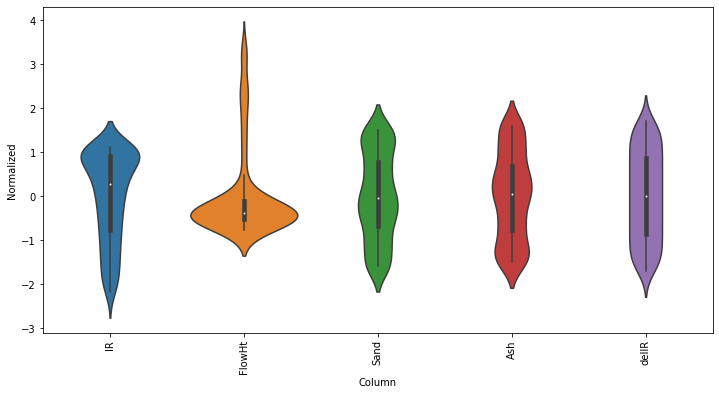

In [4]:
df_mean = df.mean()
df_std = df.std()
df_std_s = (df - df_mean) / df_std
df_std_m = df_std_s.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std_m)
_ = ax.set_xticklabels(df.keys(), rotation=90)
df_std_s.describe()

In [5]:
# data
df_org = df
#df = df_std_s

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)*0.5

curve_0 = df[0:int(n*0.25)].copy()
curve_1 = df[int(n*0.25):int(n*0.5)].copy()
curve_2 = df[int(n*0.5):int(n*0.75)].copy()
curve_3 = df[int(n*0.75):int(n)].copy()
curve_4 = df[int(n):].copy()
#train_df_s = train_df_s.reset_index(drop=True)

In [6]:
df.describe()
#print(df[58:116])

,IR,FlowHt,Sand,Ash,delIR
count,464.000000,464.000000,464.000000,464.000000,464.000000
mean,0.719750,18.216106,0.562500,0.437500,-0.014250
std,0.250962,23.804094,0.292666,0.292666,0.008379
min,0.173500,0.000000,0.100000,0.000000,-0.028500
25%,0.527000,5.900000,0.362500,0.212500,-0.021500
50%,0.789750,8.882400,0.550000,0.450000,-0.014250
75%,0.947500,15.364700,0.787500,0.637500,-0.007000
max,1.000000,98.685300,1.000000,0.900000,0.000000


In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### 1. Indexes and offsets
Start by creating the WindowGenerator class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Datasets` of windows later.

#### Window information

In [8]:
w1 = Class_t.WindowGenerator(input_width=3, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['FlowHt'])
w1

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['FlowHt']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.
#### Example window
#### Window Shape

In [9]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[58:58+w1.total_window_size]),
                           np.array(train_df[116:116+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')




All shapes are: (batch, time, features)
Window shape: (3, 4, 5)
Inputs shape: (3, 3, 5)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

### 3. Plot

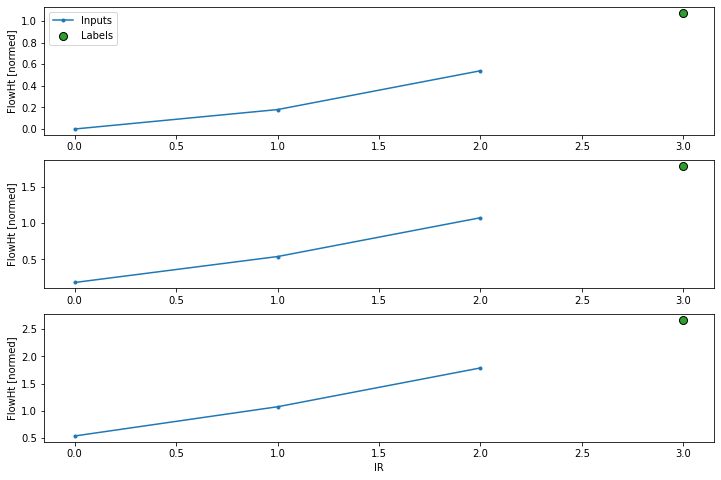

In [10]:
w1.plot()

### 4. Create `tf.data.Dataset`
Finally this `make_dataset` method will take a time series `DataFrame` and
convert it to a `tf.data.Dataset` of (`input_window`, `label_window`) pairs using
the `preprocessing.timeseries_dataset_from_array` function.

The `WindowGenerator` object holds training, validation and test data.
Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method.
Also add a standard example batch for easy access and plotting:
Now the WindowGenerator object gives you access to the `tf.data.Dataset` objects,
so you can easily iterate over the data.
The `Dataset.element_spe`c property tells you the structure, `dtypes` and shapes of the dataset elements.


In [11]:
# Each element is an (inputs, label) pair
w1.train.element_spec

(TensorSpec(shape=(None, 3, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [12]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (16, 3, 5)
Labels shape (batch, time, features): (16, 1, 1)


In [13]:
ds = w1.train
for i, batch in enumerate(ds):
  if i < 2 :
    example_inputs, example_labels = batch
    print(f'i= {i} ',f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'      Labels shape (batch, time, features): {example_labels.shape}')
  else: break

i= 0  Inputs shape (batch, time, features): (16, 3, 5)
      Labels shape (batch, time, features): (16, 1, 1)
i= 1  Inputs shape (batch, time, features): (16, 3, 5)
      Labels shape (batch, time, features): (16, 1, 1)


#### Mapping

In [14]:
######################################################### mapping tf dataset
import numpy as np
import tensorflow as tf
# MAP
#x = np.array([[1],[2],[3],[4],[5],[6],[7] ])
x = np.array([[1,2,3,4,5,6],[12,13,14,15,16,17],[23,24,25,26,27,28]])

#x = np.array([1, 2,3,4,5,6,7,8 ])
#x =np.array([  [  [1, 2, 3],
#                  [2, 3, 4],
#                  [3, 4, 5]],
#                            [[11, 12, 13],
#                             [12, 13, 14],
 #                            [13, 14, 15]   ],
 #            [[21, 22, 23],[22, 23, 24],[23, 24, 25]],
  #            [[31, 32, 33],[32, 33, 34],[33, 34, 35]]
   #         ])
#y = np.array([ [5],[6],[7]])
# make a dataset from a numpy array
dataset = tf.data.Dataset.from_tensor_slices(x)

def map_fn(features  ):
#  f1 = fea[0:5]
  f1 = features[slice1]
  f2 = features[slice2]
  return f1, f2
#dataset = dataset.map(lambda x: x*2)
#xslice = slice(0,6,1)
slice1 = slice(0,5,1)  # 1D only
slice2 = slice(5,6,1)

dataset = dataset.map(map_fn)

for batch in dataset:
    f1, f2 = batch
    print(f'*** f1 = {f1}')
    print(f'*** f2 = {f2}')

*** f1 = [1 2 3 4 5]
*** f2 = [6]
*** f1 = [12 13 14 15 16]
*** f2 = [17]
*** f1 = [23 24 25 26 27]
*** f2 = [28]


In [15]:
x.shape

(3, 6)

In [16]:
print(tf.slice(x, [1,0 ], [2, 4]))

tf.Tensor(
[[12 13 14 15]
 [23 24 25 26]], shape=(2, 4), dtype=int32)


In [17]:
t = tf.constant([[[1, 1, 1], [2, 2, 2]],
                 [[3, 3, 3], [4, 4, 4]],
                 [[5, 5, 5], [6, 6, 6]]])
print(t)
print(tf.slice(t, [1, 0, 0], [1, 1, 3]))  # [[[3, 3, 3]]]
print(tf.slice(t, [1, 0, 0], [1, 2, 3]))  # [[[3, 3, 3],
                                   #   [4, 4, 4]]]
print(tf.slice(t, [1, 0, 0], [2, 1, 3]))  # [[[3, 3, 3]],
                                   #  [[5, 5, 5]]]

tf.Tensor(
[[[1 1 1]
  [2 2 2]]

 [[3 3 3]
  [4 4 4]]

 [[5 5 5]
  [6 6 6]]], shape=(3, 2, 3), dtype=int32)
tf.Tensor([[[3 3 3]]], shape=(1, 1, 3), dtype=int32)
tf.Tensor(
[[[3 3 3]
  [4 4 4]]], shape=(1, 2, 3), dtype=int32)
tf.Tensor(
[[[3 3 3]]

 [[5 5 5]]], shape=(2, 1, 3), dtype=int32)


In [18]:
class A:
    def __getitem__(self, item):
        print(repr(item))

a = A()

a[1]
a[1:2]
a[1:2:5]

1
slice(1, 2, None)
slice(1, 2, 5)


#### conv_window

In [19]:
CONV_WIDTH = 3
conv_window = Class_t.WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
        train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['FlowHt'])

conv_window

conv_window_t = Class_t.WinGen(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
        train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['FlowHt'])

conv_window_t

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['FlowHt']

In [20]:
LABEL_WIDTH = 8
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wide_conv_window = Class_t.WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['FlowHt'])

wide_conv_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 3  4  5  6  7  8  9 10]
Label column name(s): ['FlowHt']

In [ ]:
wide_conv_window_t = Class_t.WinGen(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['FlowHt'])

wide_conv_window_t

### Convolution Model

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:

_ = compile.compile_2(conv_model)





